# Deep Latent Policy Gradient for Ant

In [1]:
import gym,warnings,time
warnings.filterwarnings("ignore") # Stop annoying warnings
gym.logger.set_level(40)
import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
%matplotlib inline
import skvideo.io
from datetime import datetime
from custom_ant import AntEnvCustom # Custom ant 
from lgrp_class import lgrp_class # Gaussian random path
from vae_class import vae_class # VAE
from antTrainEnv_class import antTrainEnv_class
from util import PID_class,display_frames_as_gif,\
    quaternion_to_euler_angle,multi_dim_interp,cpu_sess,gpu_sess,Scaler
print ("TF version is [%s]."%(tf.__version__))

Instructions for updating:
Use the retry module or similar alternatives.
Class Ready
TF version is [1.7.0].


### Instantiate Class

Custom Ant Environment made by SJ.


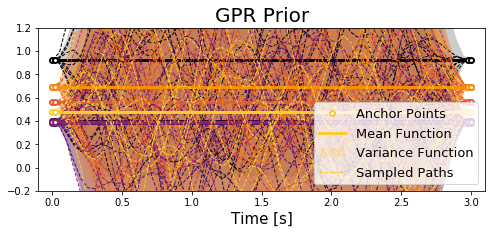

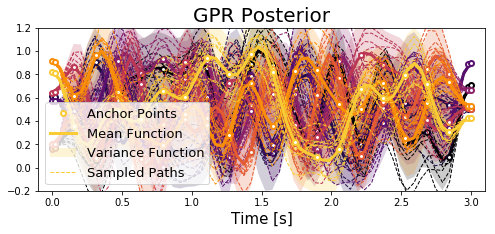

In [2]:
tf.reset_default_graph() # Reset Graph
AntEnv = antTrainEnv_class(_PLOT_GRP=True)

### Sample from prior and rollout => Set posterior and rollout from mean and sampled

[Prior] avgRwd:[-1.219] xDisp:[0.036] hDisp:[-87.871]
[Mean]  avgRwd:[-1.072] xDisp:[0.830] hDisp:[185.342]
[Post]  avgRwd:[-1.225] xDisp:[0.699] hDisp:[-52.224]


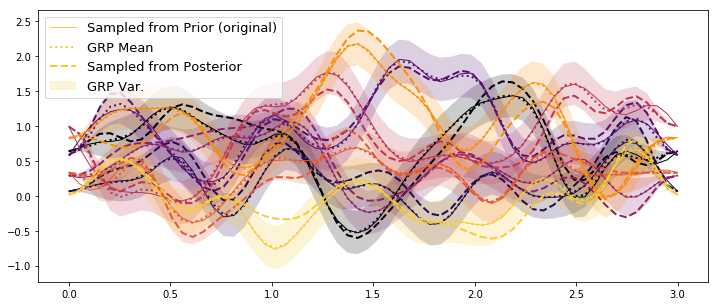

In [3]:
AntEnv.basic_test()

### Train Ant

In [4]:
SAVE_VID = True
MAKE_GIF = False # Probably unnecessary 
PLOT_GRP = False

In [5]:
sess = gpu_sess()
np.random.seed(seed=0)
tf.set_random_seed(seed=0)
sess.run(tf.global_variables_initializer()) # Initialize VAE weights

maxEpoch  = 100
batchSize = 50
# Expirence memory
xList = np.zeros((batchSize,AntEnv.env.actDim*AntEnv.nAnchor))
qList = np.zeros((batchSize))
xLists = ['']*maxEpoch
qLists = ['']*maxEpoch
xDispList = np.zeros((batchSize))
rAvgList = np.zeros((batchSize))
rContactList = np.zeros((batchSize))
rCtrlList = np.zeros((batchSize))
rFwdList = np.zeros((batchSize))
rSrvList = np.zeros((batchSize))

print ("Start training...")
for _epoch in range(maxEpoch):
    priorProb = 1.0*np.exp(-4*(_epoch/maxEpoch)**2) # Schedule eps-greedish..
    for _iter in range(batchSize):  
        np.random.seed(seed=(_epoch*batchSize+_iter))
        # np.random.seed((int)(time.time())) # Shuffle seed 
        if (np.random.rand()<priorProb) | (_epoch==0): # Sample from prior
            avgRwd,ret = AntEnv.unit_rollout_from_grp_prior(AntEnv.maxRepeat)
        else: # Sample from posterior (VAE)
            sampledX = AntEnv.VAE.sample(_sess=sess).reshape((AntEnv.nAnchor,AntEnv.env.actDim))
            sampledX = (sampledX-sampledX.min())/(sampledX.max()-sampledX.min())
            AntEnv.set_anchor_grp_posterior(_anchors=sampledX,_levBtw=0.9)
            avgRwd,ret = AntEnv.unit_rollout_from_grp_posterior(AntEnv.maxRepeat)
        # Get anchor points
        xInterp = AntEnv.get_anchor_from_traj(ret['sampledTraj'])
        xVec = np.reshape(xInterp,newshape=(1,-1))
        # Append
        xList[_iter,:] = xVec
        qList[_iter] = avgRwd
        xDispList[_iter] = ret['xDisp']
        rAvgList[_iter] = ret['rAvg']
        rContactList[_iter] = ret['rContactAvg']
        rCtrlList[_iter] = ret['rCtrlAvg']
        rFwdList[_iter] = ret['rFwdAvg']
        rSrvList[_iter] = ret['rSrvAvg']
        # Print 
        PRINT_EACH_ROLLOUT = False
        if PRINT_EACH_ROLLOUT:
            print ("  [%d/%d][%d/%d] rwd:[%.2f] xDisp:[%.3f] hDisp:[%.1f]"%
                   (_epoch,maxEpoch,_iter,batchSize,avgRwd,ret['xDisp'],ret['hDisp']))
    # Train
    xLists[_epoch] = xList
    qLists[_epoch] = qList
    # Get the best out of previous episodes 
    for _bIdx in range(0,10):
        if _bIdx == 0: # Add current one for sure 
            xAccList = xList
            qAccList = qList
        else:
            xAccList = np.concatenate((xAccList,xLists[max(0,_epoch-_bIdx)]),axis=0)
            qAccList = np.concatenate((qAccList,qLists[max(0,_epoch-_bIdx)]))
    # Add high q episodes (5)
    sortedIdx = np.argsort(-qAccList)
    xTrain = xAccList[sortedIdx[:5],:]
    qTrain = qAccList[sortedIdx[:5]]
    # Add current episodes (batchSize)
    xTrain = np.concatenate((xTrain,xList),axis=0)
    qTrain = np.concatenate((qTrain,qList))
    # Add random episodes (batchSize)
    randIdx = np.random.permutation(xAccList.shape[0])[:batchSize]
    xRand = xAccList[randIdx,:]
    qRand = qAccList[randIdx]
    xTrain = np.concatenate((xTrain,xRand),axis=0)
    qTrain = np.concatenate((qTrain,qRand))
    
    # Train
    AntEnv.qScaler.update(qTrain) # Update Q scaler
    qScale,qOffset = AntEnv.qScaler.get() # Scaler 
    AntEnv.VAE.train(_sess=sess,_X=xTrain,_Y=None,_C=None,_Q=qScale*(qTrain-qOffset),
                     _maxIter=1e3,_batchSize=64,_PRINT_EVERY=0,_PLOT_EVERY=0,_INIT_VAR=False)
    # Print
    print ("[%d/%d](#total:%d) priorProb:[%.2f] avgRwd:[%.3f] XdispMean:[%.3f] XdispVar:[%.3f]"%
           (_epoch,maxEpoch,(_epoch+1)*batchSize,priorProb,qList.mean(),
            xDispList.mean(),xDispList.var()))
    print ("    rAvg:[%.3f] = (contact:%.3f+ctrl:%.3f+dist:%.3f+survive:%.3f)"%
           (rAvgList.mean(),rContactList.mean(),rCtrlList.mean(),rFwdList.mean(),rSrvList.mean()))
    # SHOW EVERY 
    PLOT_EVERY = 20
    if ((_epoch%PLOT_EVERY)==0 ) | (_epoch==(maxEpoch-1)):
        # Rollout 
        sampledX = AntEnv.VAE.sample(_sess=sess).reshape((AntEnv.nAnchor,AntEnv.env.actDim))
        sampledX = (sampledX-sampledX.min())/(sampledX.max()-sampledX.min())
        AntEnv.set_anchor_grp_posterior(_anchors=sampledX,_levBtw=0.8)
        avgRwd,ret = AntEnv.unit_rollout_from_grp_mean(
                _maxRepeat=AntEnv.maxRepeat,_DO_RENDER=True)
        print ("  [^] avgRwd:[%.3f] Xdisp:[%.3f] hDisp:[%.1f]"%(avgRwd,ret['xDisp'],ret['hDisp']))
        # Make video
        if SAVE_VID:
            outputdata = np.asarray(ret['frames']).astype(np.uint8)
            vidName = 'vids/ant_dlpg_epoch%03d.mp4'%(_epoch)
            skvideo.io.vwrite(vidName,outputdata)
            print ("[%s] saved."%(vidName))
        # Make GIF 
        if MAKE_GIF:
            NSKIP = 3 # For memory issues
            display_frames_as_gif(ret['frames'][::NSKIP],_intv_ms=20,_figsize=(8,8),_fontsize=15,
                                  _titleStrs=ret['titleStrs'][::NSKIP])
        # Plot sampled trajectories 
        if PLOT_GRP:
            nrTrajectories2plot = 3
            for _i in range(nrTrajectories2plot):
                np.random.seed(seed=_i)
                sampledX = AntEnv.VAE.sample(_sess=sess).reshape((AntEnv.nAnchor,AntEnv.env.actDim))
                sampledX = (sampledX-sampledX.min())/(sampledX.max()-sampledX.min())
                AntEnv.set_anchor_grp_posterior(_anchors=sampledX,_levBtw=0.9)
                AntEnv.GRPposterior.plot_all(_nPath=1,_figsize=(8,3))
                avgRwd,ret = AntEnv.unit_rollout_from_grp_mean(_maxRepeat=3,_DO_RENDER=False)
                print ("  [^] avgRwd:[%.3f] Xdisp:[%.3f] hDisp:[%.1f]"%(avgRwd,ret['xDisp'],ret['hDisp']))

Start training...
[0/100](#total:50) priorProb:[1.00] avgRwd:[-0.739] XdispMean:[0.199] XdispVar:[3.704]
    rAvg:[-0.739] = (contact:-0.001+ctrl:-1.760+dist:0.022+survive:1.000)
Creating window glfw
  [^] avgRwd:[1.010] Xdisp:[2.154] hDisp:[10.0]
[vids/ant_dlpg_epoch000.mp4] saved.
[1/100](#total:100) priorProb:[1.00] avgRwd:[-0.670] XdispMean:[0.047] XdispVar:[3.727]
    rAvg:[-0.670] = (contact:-0.001+ctrl:-1.674+dist:0.005+survive:1.000)
[2/100](#total:150) priorProb:[1.00] avgRwd:[-0.682] XdispMean:[-0.198] XdispVar:[3.019]
    rAvg:[-0.682] = (contact:-0.001+ctrl:-1.659+dist:-0.022+survive:1.000)
[3/100](#total:200) priorProb:[1.00] avgRwd:[-0.685] XdispMean:[-0.070] XdispVar:[2.318]
    rAvg:[-0.685] = (contact:-0.001+ctrl:-1.676+dist:-0.008+survive:1.000)
[4/100](#total:250) priorProb:[0.99] avgRwd:[-0.739] XdispMean:[-0.103] XdispVar:[2.096]
    rAvg:[-0.739] = (contact:-0.001+ctrl:-1.726+dist:-0.011+survive:1.000)
[5/100](#total:300) priorProb:[0.99] avgRwd:[-0.716] XdispMean

[49/100](#total:2500) priorProb:[0.38] avgRwd:[0.172] XdispMean:[0.913] XdispVar:[3.199]
    rAvg:[0.172] = (contact:-0.002+ctrl:-0.927+dist:0.101+survive:1.000)
[50/100](#total:2550) priorProb:[0.37] avgRwd:[0.242] XdispMean:[1.078] XdispVar:[2.076]
    rAvg:[0.242] = (contact:-0.002+ctrl:-0.876+dist:0.120+survive:1.000)
[51/100](#total:2600) priorProb:[0.35] avgRwd:[0.339] XdispMean:[1.351] XdispVar:[2.781]
    rAvg:[0.339] = (contact:-0.002+ctrl:-0.809+dist:0.150+survive:1.000)
[52/100](#total:2650) priorProb:[0.34] avgRwd:[0.268] XdispMean:[1.613] XdispVar:[2.776]
    rAvg:[0.268] = (contact:-0.002+ctrl:-0.909+dist:0.179+survive:1.000)
[53/100](#total:2700) priorProb:[0.33] avgRwd:[0.455] XdispMean:[1.366] XdispVar:[3.776]
    rAvg:[0.455] = (contact:-0.002+ctrl:-0.695+dist:0.152+survive:1.000)
[54/100](#total:2750) priorProb:[0.31] avgRwd:[0.388] XdispMean:[1.077] XdispVar:[2.046]
    rAvg:[0.388] = (contact:-0.002+ctrl:-0.729+dist:0.120+survive:1.000)
[55/100](#total:2800) priorP

[99/100](#total:5000) priorProb:[0.02] avgRwd:[0.881] XdispMean:[1.532] XdispVar:[1.095]
    rAvg:[0.881] = (contact:-0.002+ctrl:-0.287+dist:0.170+survive:1.000)
  [^] avgRwd:[1.306] Xdisp:[3.433] hDisp:[-75.1]
[vids/ant_dlpg_epoch099.mp4] saved.


### Make Final vid

In [6]:
SAVE_VID_FINAL = True
MAKE_GIF_FINAL = False
PLOT_GRP_FINAL = True

  [^] avgRwd:[1.305] Xdisp:[3.429] Hdisp:[-65.263]
[vids/ant_dlpg_final_0.mp4] saved.


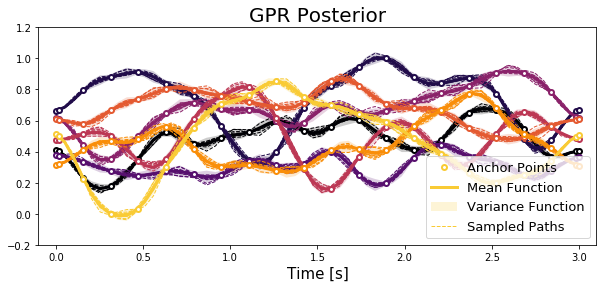

  [^] avgRwd:[1.290] Xdisp:[3.291] Hdisp:[-76.338]
[vids/ant_dlpg_final_1.mp4] saved.


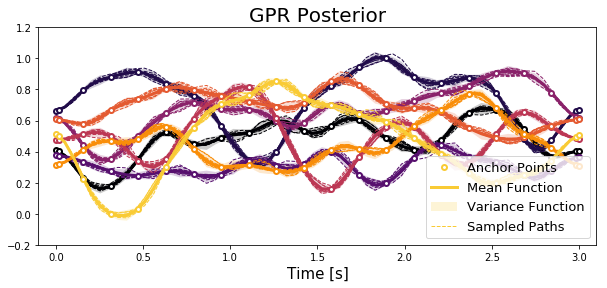

  [^] avgRwd:[1.314] Xdisp:[3.506] Hdisp:[-61.052]
[vids/ant_dlpg_final_2.mp4] saved.


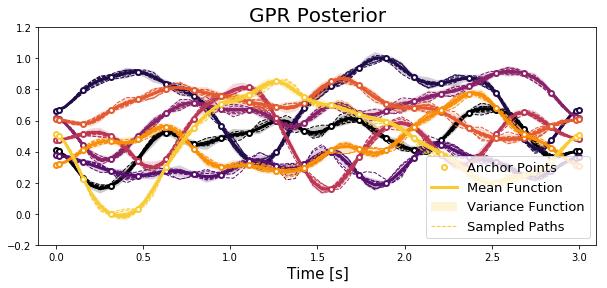

In [7]:
for _i in range(3):
    np.random.seed(seed=_i+100)
    sampledX = AntEnv.VAE.sample(_sess=sess).reshape((AntEnv.nAnchor,AntEnv.env.actDim))
    sampledX = (sampledX-sampledX.min())/(sampledX.max()-sampledX.min())
    AntEnv.set_anchor_grp_posterior(_anchors=sampledX,_levBtw=0.99)
    avgRwd,ret = AntEnv.unit_rollout_from_grp_mean(_maxRepeat=3,_DO_RENDER=True)
    print ("  [^] avgRwd:[%.3f] Xdisp:[%.3f] Hdisp:[%.3f]"%(avgRwd,ret['xDisp'],ret['hDisp']))
    if SAVE_VID_FINAL:
        outputdata = np.asarray(ret['frames']).astype(np.uint8)
        vidName = 'vids/ant_dlpg_final_%d.mp4'%(_i)
        skvideo.io.vwrite(vidName,outputdata)
        print ("[%s] saved."%(vidName))
    if MAKE_GIF_FINAL:
        display_frames_as_gif(ret['frames'],_intv_ms=20,_figsize=(6,6),_fontsize=15,
                              _titleStrs=ret['titleStrs'])
    if PLOT_GRP_FINAL:
        AntEnv.GRPposterior.plot_all(_nPath=10,_figsize=(10,4))